In [1]:
import pennylane as qml
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer
from pennylane import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from scipy.integrate import quad

In [2]:
np.random.seed(32)

### Data Load

In [3]:
### x, q data
data = np.load('/Users/heechanyi/Desktop/Project/Calculus model/Data/uquarkpdf_10e4.npz') 

In [4]:
### xdata
data = np.load('/Users/heechanyi/Desktop/Project/Calculus model/Data/uquark.npz') 

In [5]:
xdata = data['x']
ydata = data['y']
print(xdata)
print(ydata)

[1.00000000e-04 1.15139540e-04 1.32571137e-04 1.52641797e-04
 1.75751062e-04 2.02358965e-04 2.32995181e-04 2.68269580e-04
 3.08884360e-04 3.55648031e-04 4.09491506e-04 4.71486636e-04
 5.42867544e-04 6.25055193e-04 7.19685673e-04 8.28642773e-04
 9.54095476e-04 1.09854114e-03 1.26485522e-03 1.45634848e-03
 1.67683294e-03 1.93069773e-03 2.22299648e-03 2.55954792e-03
 2.94705170e-03 3.39322177e-03 3.90693994e-03 4.49843267e-03
 5.17947468e-03 5.96362332e-03 6.86648845e-03 7.90604321e-03
 9.10298178e-03 1.04811313e-02 1.20679264e-02 1.38949549e-02
 1.59985872e-02 1.84206997e-02 2.12095089e-02 2.44205309e-02
 2.81176870e-02 3.23745754e-02 3.72759372e-02 4.29193426e-02
 4.94171336e-02 5.68986603e-02 6.55128557e-02 7.54312006e-02
 8.68511374e-02 1.00000000e-01 1.00000000e-01 1.16326531e-01
 1.32653061e-01 1.48979592e-01 1.65306122e-01 1.81632653e-01
 1.97959184e-01 2.14285714e-01 2.30612245e-01 2.46938776e-01
 2.63265306e-01 2.79591837e-01 2.95918367e-01 3.12244898e-01
 3.28571429e-01 3.448979

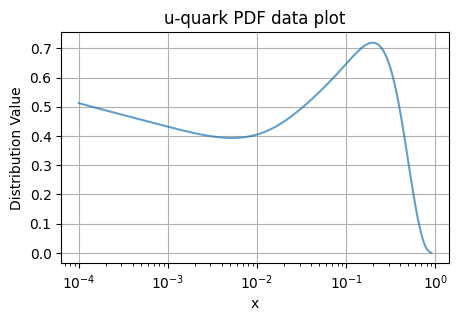

In [6]:
plt.figure(figsize=(5, 3))
plt.plot(xdata, ydata, alpha = 0.7)
plt.xscale('log')

plt.xlabel('x')
plt.ylabel('Distribution Value')
plt.title('u-quark PDF data plot')
plt.grid(True)
plt.show()

### PDF Ansatz Model

In [7]:
dev = qml.device("lightning.qubit", wires = 10)

@qml.qnode(dev)
def PDF_Ansatz(params, xdata, num_layers):
    
    idx = 0

    for _ in range(num_layers):
        #qml.RY(params[idx], wires = 0)
        qml.RY(params[idx]*xdata+params[idx+1], wires = 0, id = 'x')
        qml.RZ(params[idx+2]*np.log10(xdata)+params[idx+3], wires = 0, id = 'log x')
        qml.RY(params[idx+4]*xdata+params[idx+5], wires = 0, id = 'x')
        idx += 6

    return qml.expval(qml.PauliZ(0))


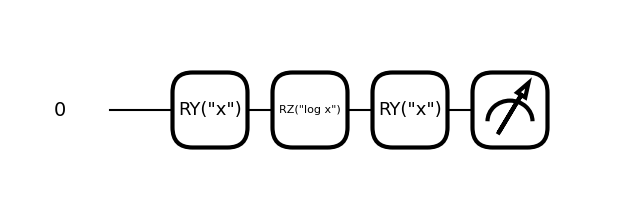

In [8]:
num_layers = 1
params = np.random.uniform(size = num_layers * 6, requires_grad = True)

fig, ax = qml.draw_mpl(PDF_Ansatz)(params, xdata, num_layers)
plt.show()

### Cost function

In [9]:
def cost_function(params, xdata, num_layers, y):
    loss = 0.0

    for i in range(len(xdata)):
        prediction = PDF_Ansatz(params, xdata[i], num_layers)
        loss += (prediction - y[i])**2

    return loss / len(xdata)

### Model Running

In [10]:
def model_running(params, x, num_layers):
    
    exp_values = []

    for i in range(len(x)):
        expval = PDF_Ansatz(params, x[i], num_layers)
        exp_values.append(expval)
        
    return np.array(exp_values)

### Utility

In [11]:
def accuracy(ypred, ydata):

    score = 0
    for i in range(len(ydata)):
        acc = ypred[i] / ydata[i] - 1
        if np.abs(acc) < 0.2:
            score += 1
    
    return score/len(ydata)

In [12]:
def iterate_minibatches(inputs, targets, batch_size):
    
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

-----

In [13]:
data = np.load('/Users/heechanyi/Desktop/Project/Calculus model/Data/uquark.npz') 

In [14]:
xdata = data['x']
ydata = data['y']

In [15]:
train_data, test_data, train_target, test_target = train_test_split(xdata, ydata, test_size=0.2, random_state=32)
train_target = train_target.reshape(-1)
test_target = test_target.reshape(-1)

In [16]:
# Trainnig option settings
num_layers = 4
epochs = 100
batch_size = 50
lr = 0.03

# Using the Optimizer
opt = AdamOptimizer(lr)                 ### Adam Optimizer
#opt = GradientDescentOptimizer(lr)      ### GradientDescent based on Parmaeter Shift Rule

# Initializing random parameters for the circuit
params = np.random.uniform(size = num_layers * 6, requires_grad = True)

### Evaluating the qNN
# Running the model with test data
pred_train = model_running(params, train_data, num_layers)
score_train = accuracy(pred_train, train_target)

# Running the model with the test data
pred_test = model_running(params, test_data, num_layers)
score_test = accuracy(pred_test, test_target)

# Saving predictions with random weights for comparison 
initial_predictions = pred_test

loss = cost_function(params, test_data, num_layers, test_target)

loss_list = [loss]
accuracy_train_list = [score_train]
accuracy_test_list = [score_test]

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss.item(), score_train, score_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(train_data, train_target, batch_size=batch_size):
        params, _, _, _ = opt.step(cost_function, params, Xbatch, num_layers, ybatch)

    pred_train = model_running(params, train_data, num_layers)
    score_train = accuracy(pred_train, train_target)
    loss = cost_function(params, train_data, num_layers, train_target)

    pred_test = model_running(params, test_data, num_layers)
    score_test = accuracy(pred_test, test_target)
    res = [it + 1, loss.item(), score_train, score_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )

    loss_list.append(loss)
    accuracy_train_list.append(score_train)
    accuracy_test_list.append(score_test)

Epoch:  0 | Cost: 0.216744 | Train accuracy: 0.100000 | Test Accuracy: 0.100000
Epoch:  1 | Loss: 0.191731 | Train accuracy: 0.112500 | Test accuracy: 0.150000
Epoch:  2 | Loss: 0.117105 | Train accuracy: 0.175000 | Test accuracy: 0.150000
Epoch:  3 | Loss: 0.079847 | Train accuracy: 0.187500 | Test accuracy: 0.300000
Epoch:  4 | Loss: 0.063794 | Train accuracy: 0.200000 | Test accuracy: 0.200000
Epoch:  5 | Loss: 0.049862 | Train accuracy: 0.225000 | Test accuracy: 0.200000
Epoch:  6 | Loss: 0.034856 | Train accuracy: 0.275000 | Test accuracy: 0.300000
Epoch:  7 | Loss: 0.025103 | Train accuracy: 0.425000 | Test accuracy: 0.450000
Epoch:  8 | Loss: 0.023041 | Train accuracy: 0.162500 | Test accuracy: 0.150000
Epoch:  9 | Loss: 0.023199 | Train accuracy: 0.125000 | Test accuracy: 0.200000
Epoch: 10 | Loss: 0.021314 | Train accuracy: 0.125000 | Test accuracy: 0.200000
Epoch: 11 | Loss: 0.016975 | Train accuracy: 0.312500 | Test accuracy: 0.300000
Epoch: 12 | Loss: 0.012687 | Train accur

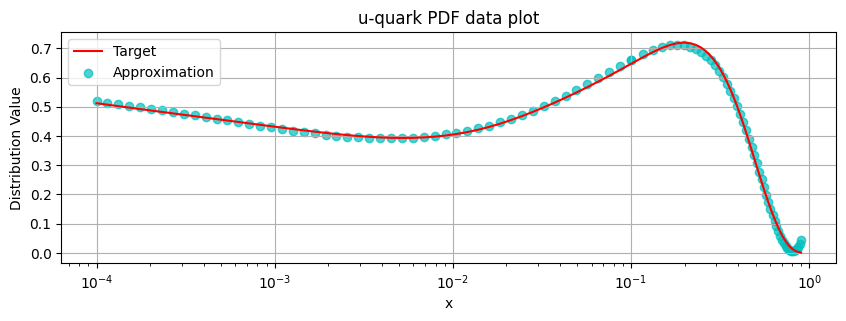

In [17]:
pred_test = model_running(params, xdata, num_layers)

fig, axis = plt.subplots(1, 1, figsize=(10, 3))
axis.plot(xdata, ydata, color = 'r', label = 'Target')
axis.scatter(xdata, pred_test, alpha = 0.7, color = 'c', label = 'Approximation')

axis.set_xscale('log')
axis.set_xlabel('x')
axis.set_ylabel('Distribution Value')
axis.set_title('u-quark PDF data plot')
axis.legend()
axis.grid(True)